In [2]:
import os
import sys
import yfinance as yf
import talib as ta
import pandas as pd
import numpy as np
import plotly.express as px
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns


In [3]:
# Get theconda create --name talib python=3.9 current working directory
current_dir = os.getcwd()
print(current_dir)

# Get the parent directory
parent_dir = os.path.dirname(current_dir)
print(parent_dir)

# Insert the path to the parent directory
sys.path.insert(0, parent_dir)

# # Insert the path to the Scripts directory
# sys.path.insert(0, os.path.join(parent_dir, 'Scripts'))

# print(sys.path)

c:\Users\smrc\Documents\GitHub\Stock-Market-Data-and-Analysis\notebooks
c:\Users\smrc\Documents\GitHub\Stock-Market-Data-and-Analysis


In [4]:
from scripts.financial_analyzer import FinancialAnalyzer

In [5]:
# Loading financial news data
news_data = pd.read_csv("C:/Users/smrc/Documents/Github/raw_analyst_ratings.csv")
news_data = news_data.loc[:, ~news_data.columns.str.contains('^Unnamed')]
print(news_data.columns.tolist())

['headline', 'url', 'publisher', 'date', 'stock']


In [6]:
news_data['date'] = pd.to_datetime(news_data['date'], errors='coerce')
news_data['date'] = news_data['date'].dt.tz_localize(None)

In [7]:
from datetime import timedelta

# Step 1: Load and Prepare the Data
tickers = ['AAPL', 'GOOG', 'META', 'TSLA', 'NVDA', 'MSFT', 'AMZN']
stock_data = {}

for ticker in tickers:
    stock_data[ticker] = yf.download(ticker, start='2020-01-01', end='2023-12-31')


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [8]:
# Convert to DataFrame and Add a 'Ticker' Column
combined_data = pd.concat(
    [df.assign(Ticker=ticker) for ticker, df in stock_data.items()],
    axis=0
)

In [9]:
# Reset the index for consistency
combined_data.reset_index(inplace=True)
print(combined_data.head())

Price        Date  Adj Close      Close       High        Low       Open  \
Ticker                  AAPL       AAPL       AAPL       AAPL       AAPL   
0      2020-01-02  72.796021  75.087502  75.150002  73.797501  74.059998   
1      2020-01-03  72.088287  74.357498  75.144997  74.125000  74.287498   
2      2020-01-06  72.662712  74.949997  74.989998  73.187500  73.447502   
3      2020-01-07  72.320984  74.597504  75.224998  74.370003  74.959999   
4      2020-01-08  73.484329  75.797501  76.110001  74.290001  74.290001   

Price        Volume Ticker Adj Close Close  ... High  Low Open Volume  \
Ticker         AAPL             GOOG  GOOG  ... MSFT MSFT MSFT   MSFT   
0       135480400.0   AAPL       NaN   NaN  ...  NaN  NaN  NaN    NaN   
1       146322800.0   AAPL       NaN   NaN  ...  NaN  NaN  NaN    NaN   
2       118387200.0   AAPL       NaN   NaN  ...  NaN  NaN  NaN    NaN   
3       108872000.0   AAPL       NaN   NaN  ...  NaN  NaN  NaN    NaN   
4       132079200.0   AAPL   

In [10]:
print(stock_data['AAPL'].head())

Price       Adj Close      Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                                        
2020-01-02  72.796021  75.087502  75.150002  73.797501  74.059998  135480400
2020-01-03  72.088287  74.357498  75.144997  74.125000  74.287498  146322800
2020-01-06  72.662712  74.949997  74.989998  73.187500  73.447502  118387200
2020-01-07  72.320984  74.597504  75.224998  74.370003  74.959999  108872000
2020-01-08  73.484329  75.797501  76.110001  74.290001  74.290001  132079200


In [11]:
for ticker in tickers:
    data = stock_data[ticker]
    
    # Ensure the 'Close' column is converted to a 1D NumPy array
    close_prices = data['Close'].values.flatten()  # Flatten in case of multidimensional issues
    
    # Check dimensions for debugging (optional)
    print(f"{ticker} - Close Prices Dimensions: {close_prices.shape}")
    
    # Add Simple Moving Average (SMA)
    data['SMA'] = ta.SMA(close_prices, timeperiod=14)
    
    # Add Relative Strength Index (RSI)
    data['RSI'] = ta.RSI(close_prices, timeperiod=14)
    
    # Add Moving Average Convergence Divergence (MACD)
    macd, macd_signal, macd_hist = ta.MACD(
        close_prices, fastperiod=12, slowperiod=26, signalperiod=9
    )
    data['MACD'] = macd
    data['MACD_Signal'] = macd_signal
    data['MACD_Hist'] = macd_hist

    print(f"Indicators for {ticker} added successfully!")

AAPL - Close Prices Dimensions: (1006,)
Indicators for AAPL added successfully!
GOOG - Close Prices Dimensions: (1006,)
Indicators for GOOG added successfully!
META - Close Prices Dimensions: (1006,)
Indicators for META added successfully!
TSLA - Close Prices Dimensions: (1006,)
Indicators for TSLA added successfully!
NVDA - Close Prices Dimensions: (1006,)
Indicators for NVDA added successfully!
MSFT - Close Prices Dimensions: (1006,)
Indicators for MSFT added successfully!
AMZN - Close Prices Dimensions: (1006,)
Indicators for AMZN added successfully!


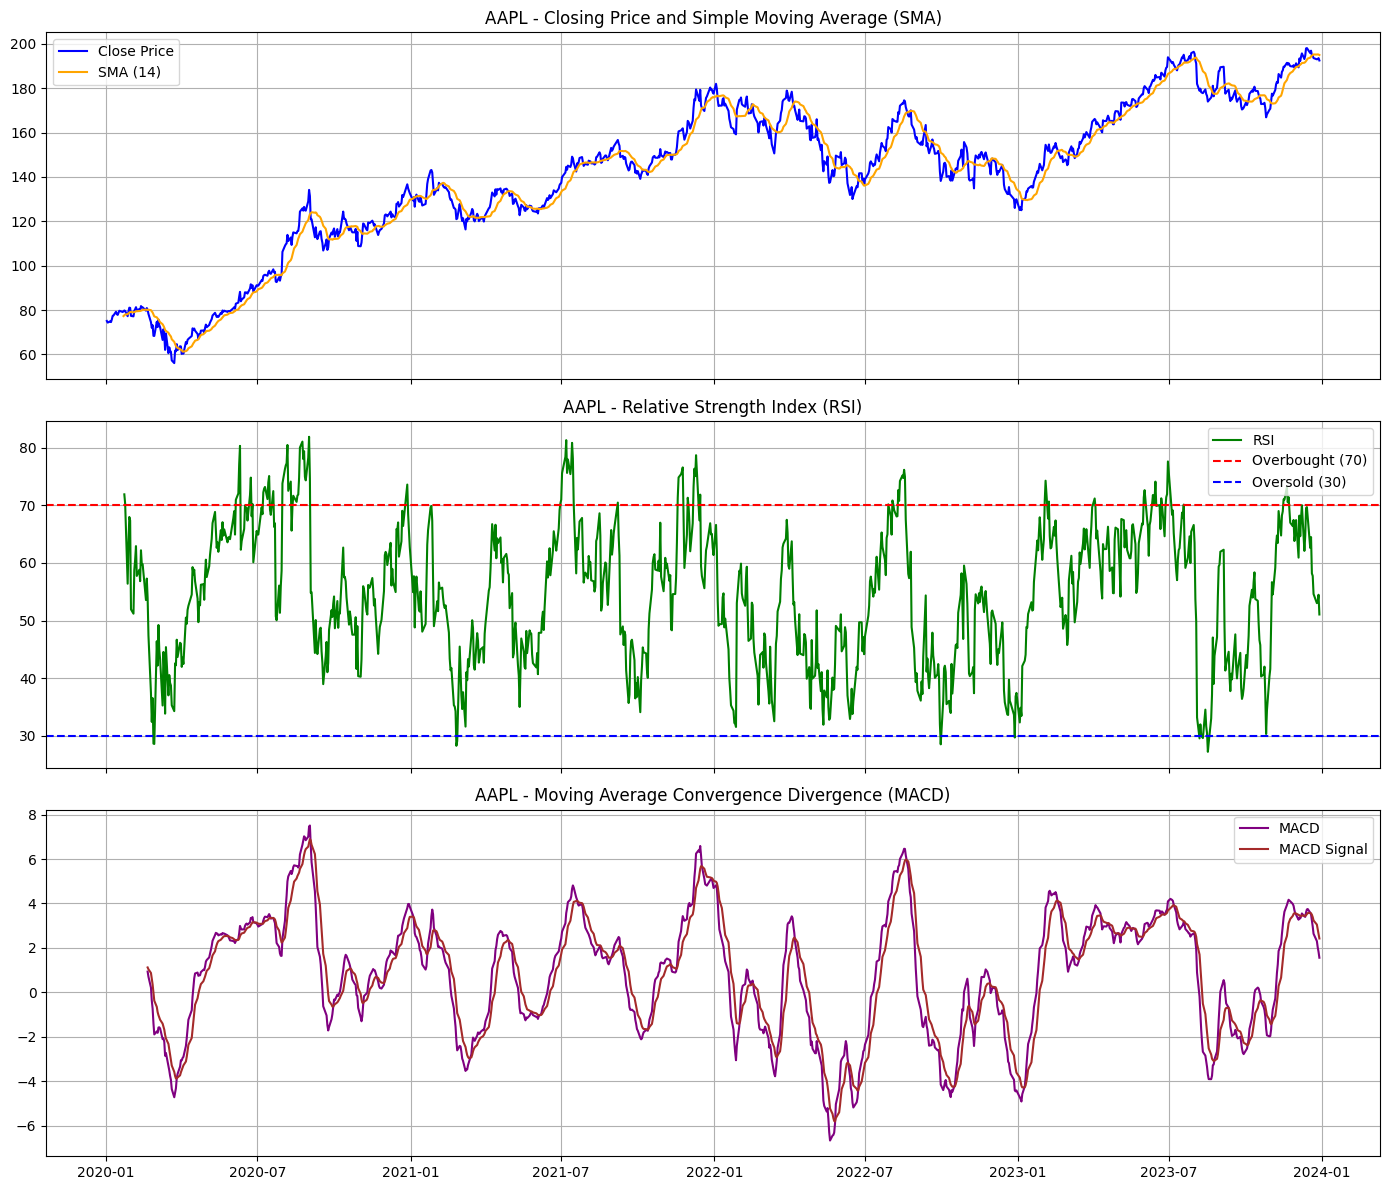

In [12]:
import matplotlib.pyplot as plt

# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

# Plot 1: Closing Price and SMA
axes[0].plot(stock_data['AAPL']['Close'], label='Close Price', color='blue')
axes[0].plot(stock_data['AAPL']['SMA'], label='SMA (14)', color='orange')
axes[0].set_title('AAPL - Closing Price and Simple Moving Average (SMA)')
axes[0].legend()
axes[0].grid()

# Plot 2: RSI
axes[1].plot(stock_data['AAPL']['RSI'], label='RSI', color='green')
axes[1].axhline(70, color='red', linestyle='--', label='Overbought (70)')
axes[1].axhline(30, color='blue', linestyle='--', label='Oversold (30)')
axes[1].set_title('AAPL - Relative Strength Index (RSI)')
axes[1].legend()
axes[1].grid()

# Plot 3: MACD
axes[2].plot(stock_data['AAPL']['MACD'], label='MACD', color='purple')
axes[2].plot(stock_data['AAPL']['MACD_Signal'], label='MACD Signal', color='brown')
axes[2].set_title('AAPL - Moving Average Convergence Divergence (MACD)')
axes[2].legend()
axes[2].grid()

# Adjust layout
plt.tight_layout()
plt.savefig("apple.png", dpi=300, bbox_inches='tight')

plt.show()


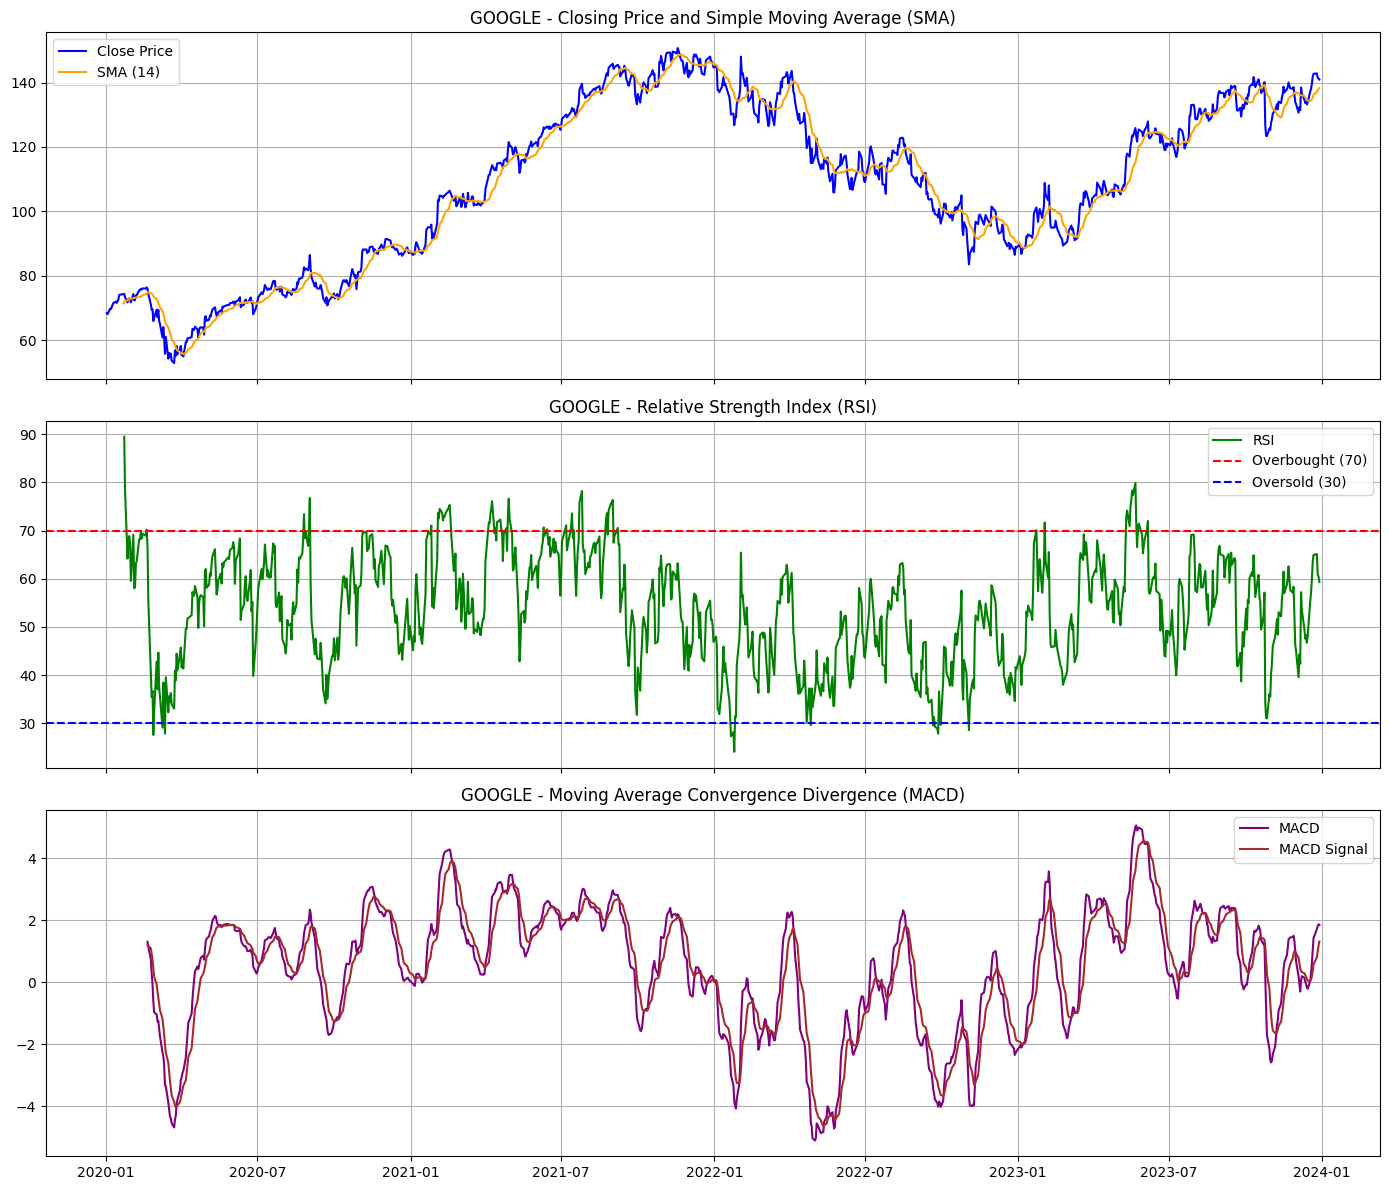

In [13]:
# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

# Plot 1: Closing Price and SMA
axes[0].plot(stock_data['GOOG']['Close'], label='Close Price', color='blue')
axes[0].plot(stock_data['GOOG']['SMA'], label='SMA (14)', color='orange')
axes[0].set_title('GOOGLE - Closing Price and Simple Moving Average (SMA)')
axes[0].legend()
axes[0].grid()

# Plot 2: RSI
axes[1].plot(stock_data['GOOG']['RSI'], label='RSI', color='green')
axes[1].axhline(70, color='red', linestyle='--', label='Overbought (70)')
axes[1].axhline(30, color='blue', linestyle='--', label='Oversold (30)')
axes[1].set_title('GOOGLE - Relative Strength Index (RSI)')
axes[1].legend()
axes[1].grid()

# Plot 3: MACD
axes[2].plot(stock_data['GOOG']['MACD'], label='MACD', color='purple')
axes[2].plot(stock_data['GOOG']['MACD_Signal'], label='MACD Signal', color='brown')
axes[2].set_title('GOOGLE - Moving Average Convergence Divergence (MACD)')
axes[2].legend()
axes[2].grid()

# Adjust layout
plt.tight_layout()
plt.savefig("google.png", dpi=300, bbox_inches='tight')
plt.show()

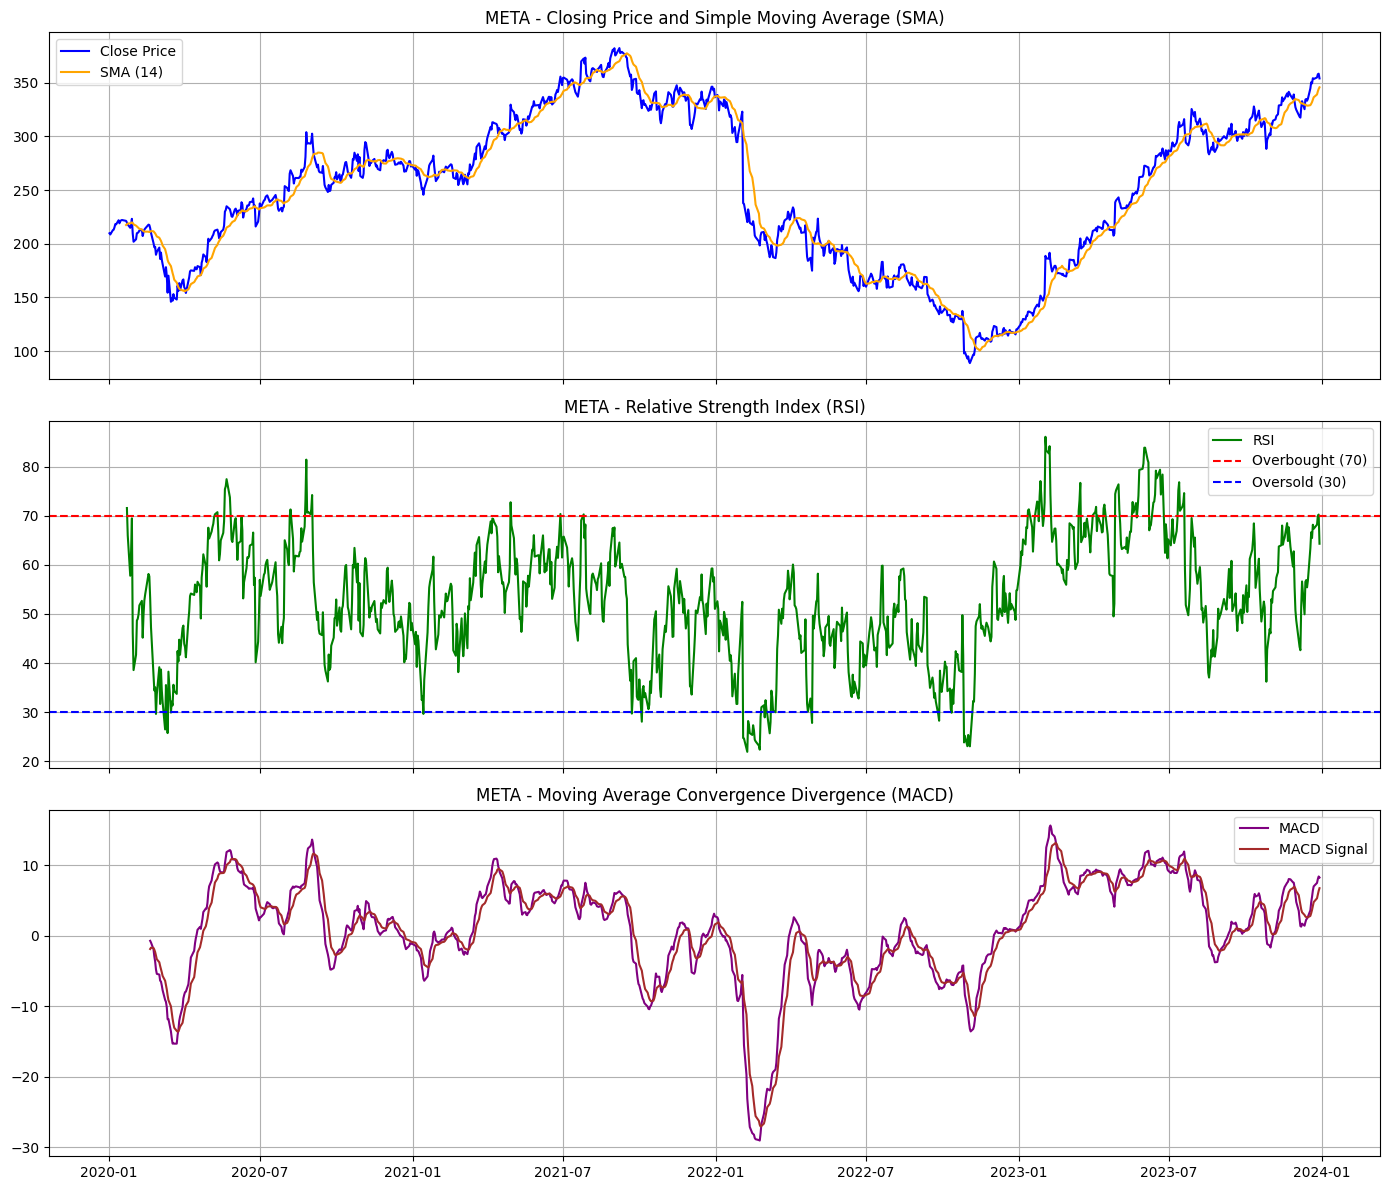

In [14]:
# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

# Plot 1: Closing Price and SMA
axes[0].plot(stock_data['META']['Close'], label='Close Price', color='blue')
axes[0].plot(stock_data['META']['SMA'], label='SMA (14)', color='orange')
axes[0].set_title('META - Closing Price and Simple Moving Average (SMA)')
axes[0].legend()
axes[0].grid()

# Plot 2: RSI
axes[1].plot(stock_data['META']['RSI'], label='RSI', color='green')
axes[1].axhline(70, color='red', linestyle='--', label='Overbought (70)')
axes[1].axhline(30, color='blue', linestyle='--', label='Oversold (30)')
axes[1].set_title('META - Relative Strength Index (RSI)')
axes[1].legend()
axes[1].grid()

# Plot 3: MACD
axes[2].plot(stock_data['META']['MACD'], label='MACD', color='purple')
axes[2].plot(stock_data['META']['MACD_Signal'], label='MACD Signal', color='brown')
axes[2].set_title('META - Moving Average Convergence Divergence (MACD)')
axes[2].legend()
axes[2].grid()

# Adjust layout
plt.tight_layout()
plt.savefig("Meta.png", dpi=300, bbox_inches='tight')
plt.show()

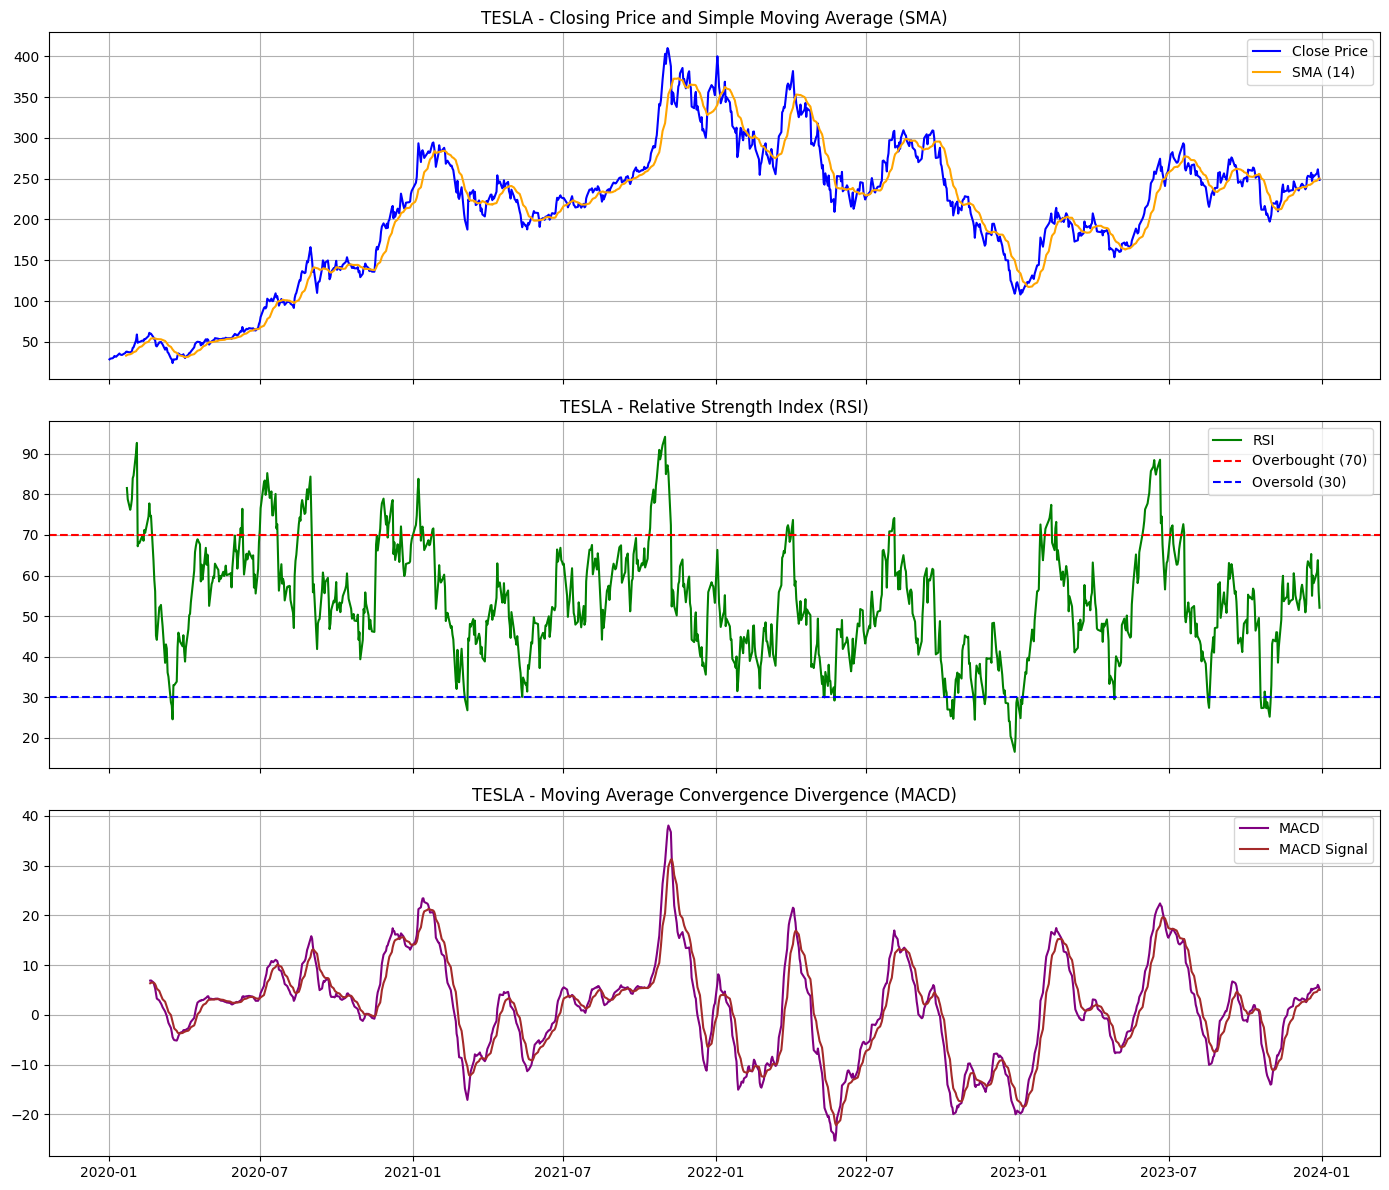

In [15]:
# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

# Plot 1: Closing Price and SMA
axes[0].plot(stock_data['TSLA']['Close'], label='Close Price', color='blue')
axes[0].plot(stock_data['TSLA']['SMA'], label='SMA (14)', color='orange')
axes[0].set_title('TESLA - Closing Price and Simple Moving Average (SMA)')
axes[0].legend()
axes[0].grid()

# Plot 2: RSI
axes[1].plot(stock_data['TSLA']['RSI'], label='RSI', color='green')
axes[1].axhline(70, color='red', linestyle='--', label='Overbought (70)')
axes[1].axhline(30, color='blue', linestyle='--', label='Oversold (30)')
axes[1].set_title('TESLA - Relative Strength Index (RSI)')
axes[1].legend()
axes[1].grid()

# Plot 3: MACD
axes[2].plot(stock_data['TSLA']['MACD'], label='MACD', color='purple')
axes[2].plot(stock_data['TSLA']['MACD_Signal'], label='MACD Signal', color='brown')
axes[2].set_title('TESLA - Moving Average Convergence Divergence (MACD)')
axes[2].legend()
axes[2].grid()

# Adjust layout
plt.tight_layout()
plt.savefig("Tesla.png", dpi=300, bbox_inches='tight')
plt.show()

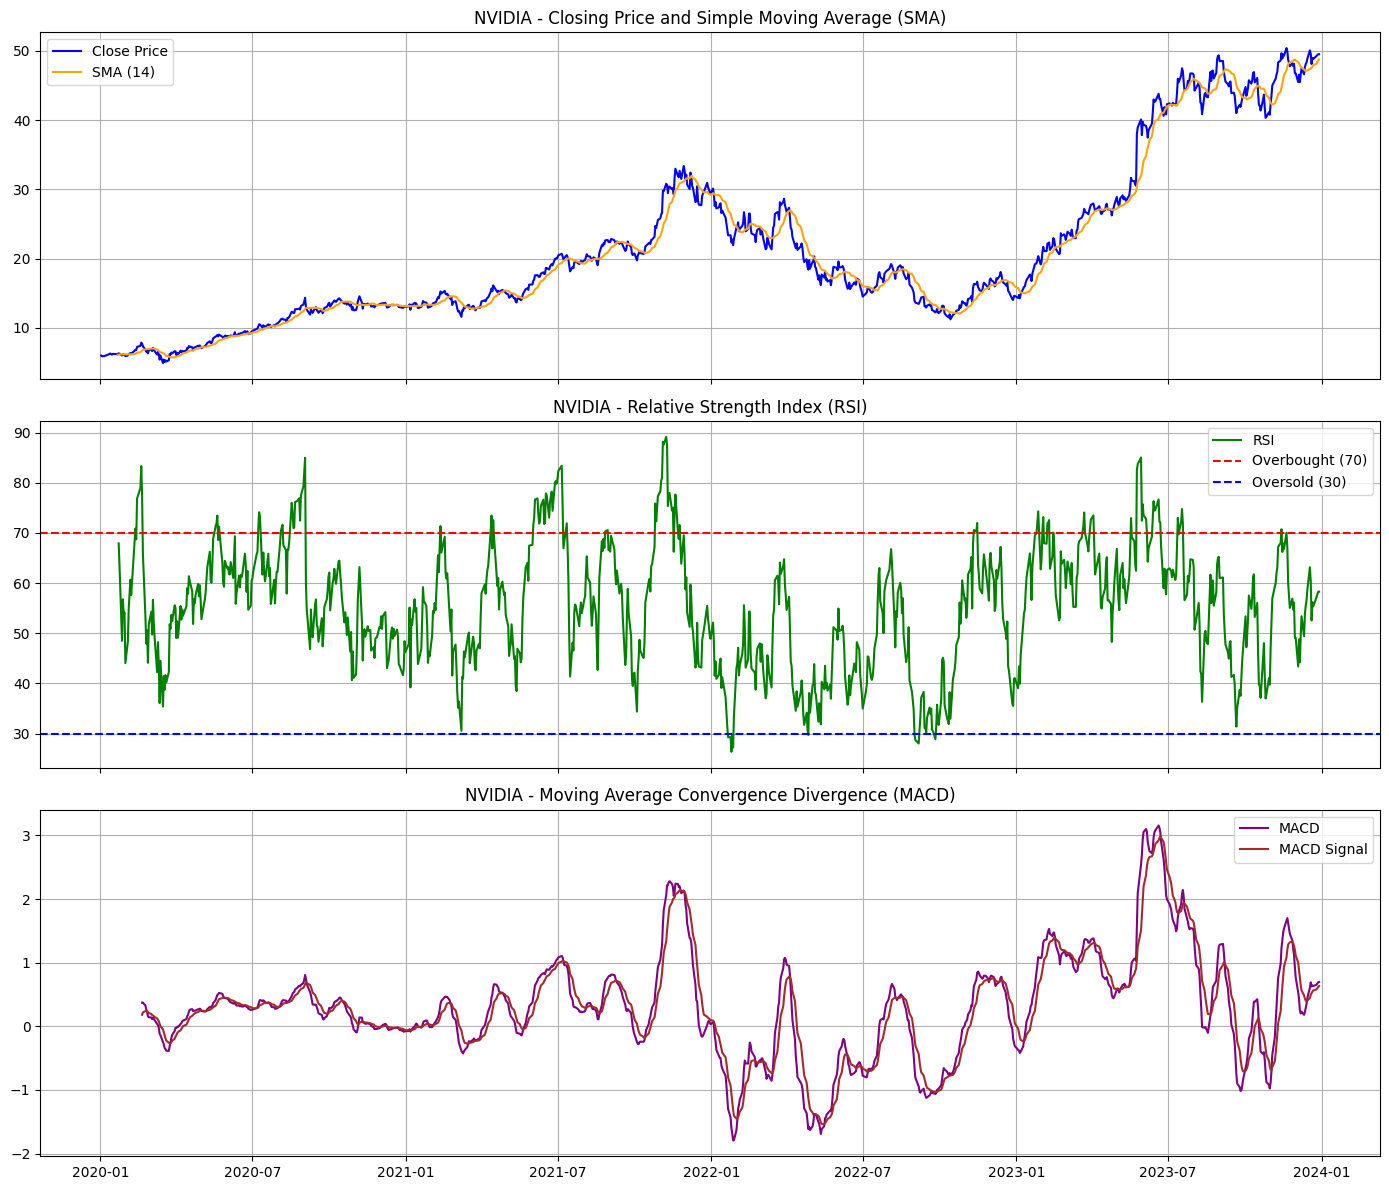

In [16]:
# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

# Plot 1: Closing Price and SMA
axes[0].plot(stock_data['NVDA']['Close'], label='Close Price', color='blue')
axes[0].plot(stock_data['NVDA']['SMA'], label='SMA (14)', color='orange')
axes[0].set_title('NVIDIA - Closing Price and Simple Moving Average (SMA)')
axes[0].legend()
axes[0].grid()

# Plot 2: RSI
axes[1].plot(stock_data['NVDA']['RSI'], label='RSI', color='green')
axes[1].axhline(70, color='red', linestyle='--', label='Overbought (70)')
axes[1].axhline(30, color='blue', linestyle='--', label='Oversold (30)')
axes[1].set_title('NVIDIA - Relative Strength Index (RSI)')
axes[1].legend()
axes[1].grid()

# Plot 3: MACD
axes[2].plot(stock_data['NVDA']['MACD'], label='MACD', color='purple')
axes[2].plot(stock_data['NVDA']['MACD_Signal'], label='MACD Signal', color='brown')
axes[2].set_title('NVIDIA - Moving Average Convergence Divergence (MACD)')
axes[2].legend()
axes[2].grid()

# Adjust layout
plt.tight_layout()
plt.savefig("nvidia.png", dpi=300, bbox_inches='tight')
plt.show()

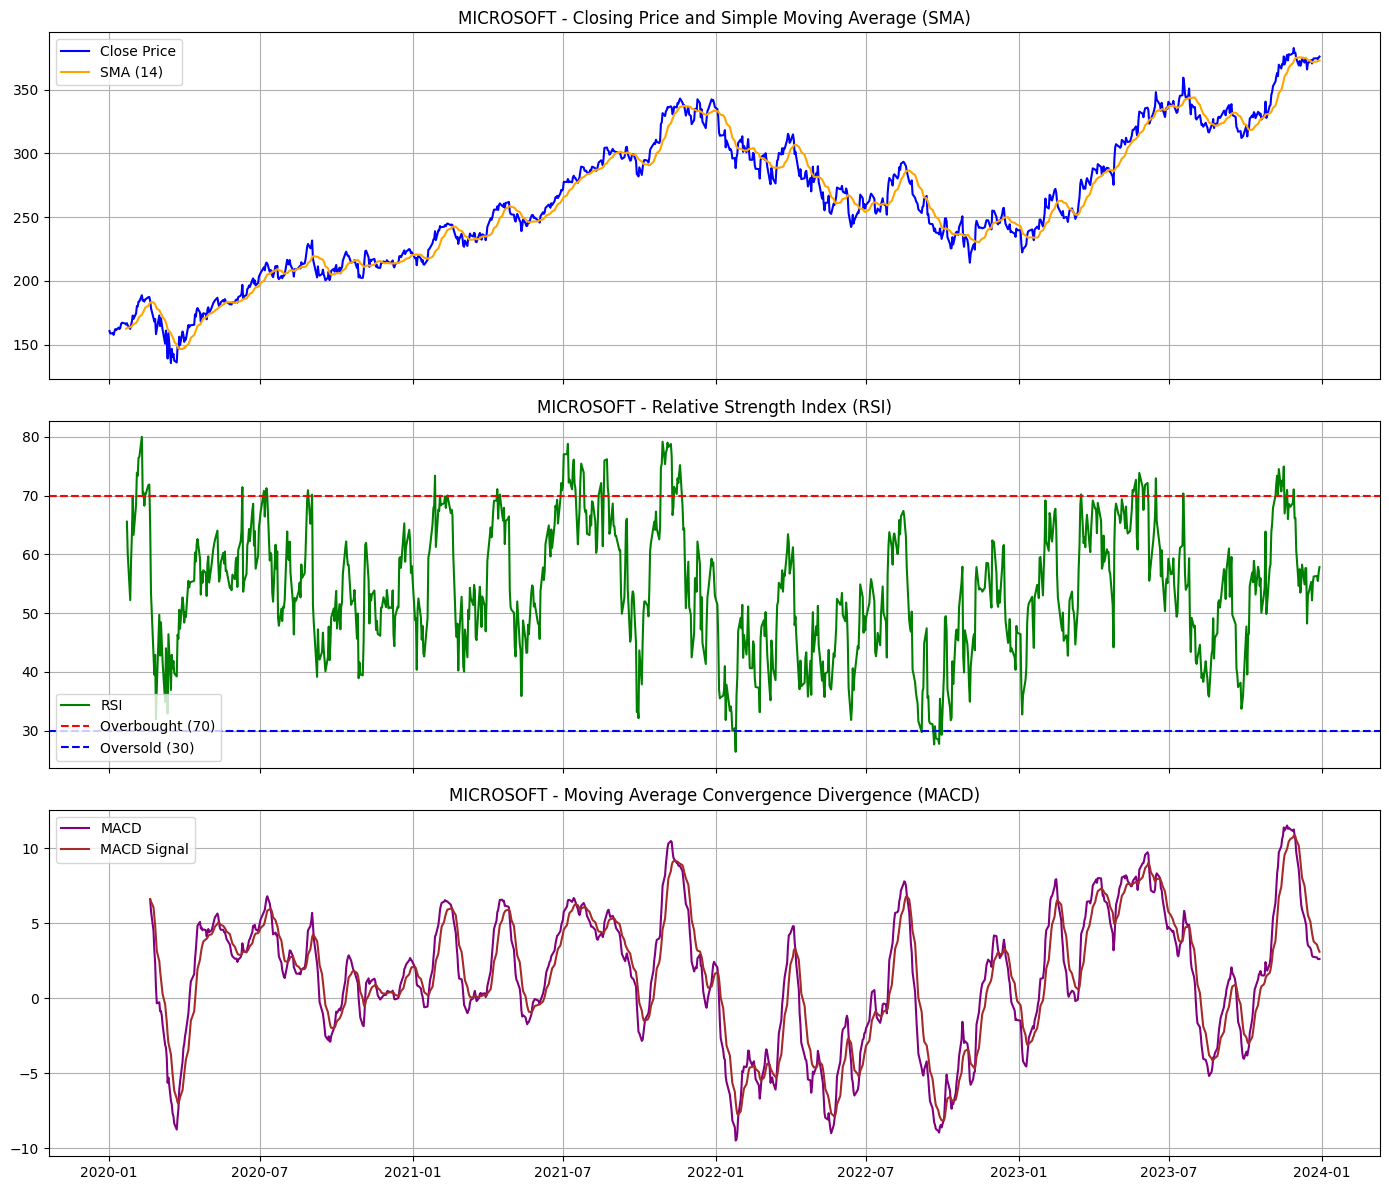

In [17]:
# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

# Plot 1: Closing Price and SMA
axes[0].plot(stock_data['MSFT']['Close'], label='Close Price', color='blue')
axes[0].plot(stock_data['MSFT']['SMA'], label='SMA (14)', color='orange')
axes[0].set_title('MICROSOFT - Closing Price and Simple Moving Average (SMA)')
axes[0].legend()
axes[0].grid()

# Plot 2: RSI
axes[1].plot(stock_data['MSFT']['RSI'], label='RSI', color='green')
axes[1].axhline(70, color='red', linestyle='--', label='Overbought (70)')
axes[1].axhline(30, color='blue', linestyle='--', label='Oversold (30)')
axes[1].set_title('MICROSOFT - Relative Strength Index (RSI)')
axes[1].legend()
axes[1].grid()

# Plot 3: MACD
axes[2].plot(stock_data['MSFT']['MACD'], label='MACD', color='purple')
axes[2].plot(stock_data['MSFT']['MACD_Signal'], label='MACD Signal', color='brown')
axes[2].set_title('MICROSOFT - Moving Average Convergence Divergence (MACD)')
axes[2].legend()
axes[2].grid()

# Adjust layout
plt.tight_layout()
plt.savefig("MSFT.png", dpi=300, bbox_inches='tight')
plt.show()

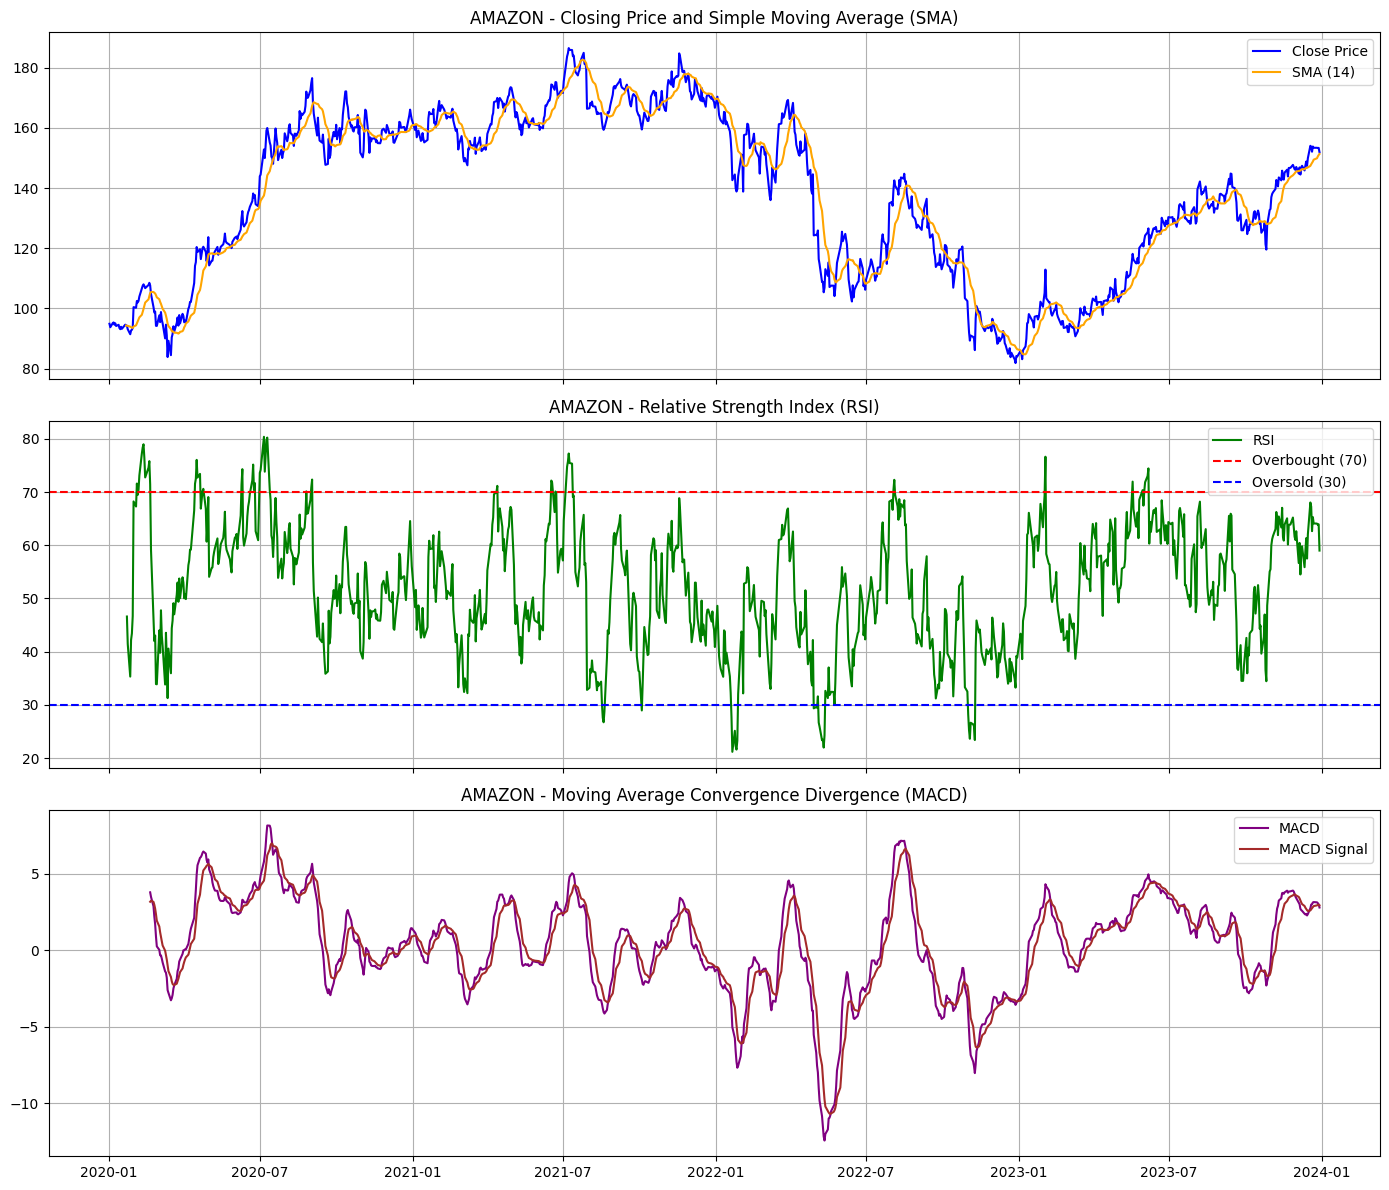

In [18]:

fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

# Plot 1: Closing Price and SMA
axes[0].plot(stock_data['AMZN']['Close'], label='Close Price', color='blue')
axes[0].plot(stock_data['AMZN']['SMA'], label='SMA (14)', color='orange')
axes[0].set_title('AMAZON - Closing Price and Simple Moving Average (SMA)')
axes[0].legend()
axes[0].grid()

# Plot 2: RSI
axes[1].plot(stock_data['AMZN']['RSI'], label='RSI', color='green')
axes[1].axhline(70, color='red', linestyle='--', label='Overbought (70)')
axes[1].axhline(30, color='blue', linestyle='--', label='Oversold (30)')
axes[1].set_title('AMAZON - Relative Strength Index (RSI)')
axes[1].legend()
axes[1].grid()

# Plot 3: MACD
axes[2].plot(stock_data['AMZN']['MACD'], label='MACD', color='purple')
axes[2].plot(stock_data['AMZN']['MACD_Signal'], label='MACD Signal', color='brown')
axes[2].set_title('AMAZON - Moving Average Convergence Divergence (MACD)')
axes[2].legend()
axes[2].grid()

# Adjust layout
plt.tight_layout()
plt.savefig("AMZN.png", dpi=300, bbox_inches='tight')
plt.show()

In [19]:
# Calculate Daily Returns for All Stocks
for ticker in tickers:
    stock_data[ticker]['Daily_Return'] = stock_data[ticker]['Close'].pct_change()

# Function to Calculate Metrics
def calculate_metrics(df, risk_free_rate=0.02):
    # Drop NaN values from returns
    returns = df['Daily_Return'].dropna()
    
    # Annualized Volatility
    annual_volatility = returns.std() * (252 ** 0.5)
    
    # Annualized Sharpe Ratio
    annualized_return = returns.mean() * 252
    sharpe_ratio = (annualized_return - risk_free_rate) / annual_volatility
    
    return annual_volatility, sharpe_ratio

# Apply to Each Stock
for ticker in tickers:
    volatility, sharpe = calculate_metrics(stock_data[ticker])
    print(f"{ticker} - Annualized Volatility: {volatility:.4f}, Annualized Sharpe Ratio: {sharpe:.4f}")


AAPL - Annualized Volatility: 0.3357, Annualized Sharpe Ratio: 0.8116
GOOG - Annualized Volatility: 0.3346, Annualized Sharpe Ratio: 0.6499
META - Annualized Volatility: 0.4678, Annualized Sharpe Ratio: 0.4760
TSLA - Annualized Volatility: 0.6810, Annualized Sharpe Ratio: 1.1065
NVDA - Annualized Volatility: 0.5423, Annualized Sharpe Ratio: 1.2088
MSFT - Annualized Volatility: 0.3263, Annualized Sharpe Ratio: 0.7557
AMZN - Annualized Volatility: 0.3769, Annualized Sharpe Ratio: 0.4483


# CORRELATION ANALYSIS BETWEEN NEWS DATA AND STOCK PRICE

In [20]:
# Step 1: Date Alignment
news_data['date'] = pd.to_datetime(news_data['date'])
combined_data['Date'] = pd.to_datetime(combined_data['Date'])

In [21]:
# Define the ticker and the time period
ticker = 'AAPL'
start_date = '2020-01-01'
end_date = '2023-12-01'

# Fetch the stock data
aapl_data = yf.download(ticker, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


In [22]:
aapl_data.head()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,,
2020-01-02,72.796036,75.087502,75.150002,73.797501,74.059998,135480400
2020-01-03,72.088295,74.357498,75.144997,74.125000,74.287498,146322800
2020-01-06,72.662704,74.949997,74.989998,73.187500,73.447502,118387200
2020-01-07,72.320984,74.597504,75.224998,74.370003,74.959999,108872000
2020-01-08,73.484344,75.797501,76.110001,74.290001,74.290001,132079200


In [42]:
aapl_data.shape


(986, 6)

In [41]:
news_data.columns.to_list()

['headline', 'url', 'publisher', 'date', 'stock']

In [40]:
# Filter news_data where stock is 'AAPL' and select date and headline columns
aapl_news_data = news_data.loc[news_data['stock'] == 'AAPL', ['date', 'headline']]

# Display the first few rows of the filtered dataset
print(aapl_news_data.head(10))


            date                                           headline
6680  2020-06-10  Tech Stocks And FAANGS Strong Again To Start D...
6681  2020-06-10      10 Biggest Price Target Changes For Wednesday
6682  2020-06-10  Benzinga Pro's Top 5 Stocks To Watch For Wed.,...
6683  2020-06-10  Deutsche Bank Maintains Buy on Apple, Raises P...
6684  2020-06-10  Apple To Let Users Trade In Their Mac Computer...
6685  2020-06-10  Big Tech Reaches New Record Heights At The Sto...
6686  2020-06-09          Why Apple's Stock Is Trading Higher Today
6687  2020-06-09  Apple Could Announce In-House Chips For Macs A...
6688  2020-06-09  Apple shares are trading higher despite market...
6689  2020-06-09  Sonos Shares Spike To Session High, Now Up 9.5...


In [43]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

# Download VADER Lexicon
nltk.download('vader_lexicon')

# Initialize Sentiment Analyzer
sia = SentimentIntensityAnalyzer()
# Add sentiment scores to the DataFrame
aapl_news_data['sentiment_score'] = aapl_news_data['headline'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Preview the updated DataFrame
print(aapl_news_data.head())

            date                                           headline  \
6680  2020-06-10  Tech Stocks And FAANGS Strong Again To Start D...   
6681  2020-06-10      10 Biggest Price Target Changes For Wednesday   
6682  2020-06-10  Benzinga Pro's Top 5 Stocks To Watch For Wed.,...   
6683  2020-06-10  Deutsche Bank Maintains Buy on Apple, Raises P...   
6684  2020-06-10  Apple To Let Users Trade In Their Mac Computer...   

      sentiment_score  
6680           0.5574  
6681           0.0000  
6682           0.2023  
6683           0.0000  
6684           0.3818  


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\smrc\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [44]:
aapl_data = aapl_data.reset_index()

print(aapl_data.columns.to_list())


['Date_', 'Adj Close_AAPL', 'Close_AAPL', 'High_AAPL', 'Low_AAPL', 'Open_AAPL', 'Volume_AAPL']


In [45]:
# Drop unnecessary columns if needed
#aapl_data.drop(columns=['level_0', 'index'], inplace=True)

# Convert the Date column to datetime format (ensure the correct column name is used)
aapl_data['Date_'] = pd.to_datetime(aapl_data['Date_'], errors='coerce')

# Drop rows with invalid dates
aapl_data.dropna(subset=['Date_'], inplace=True)

# Set the Date column as the index
aapl_data.set_index('Date_', inplace=True)

# Align dates in the news dataset as well
aapl_news_data['date'] = pd.to_datetime(aapl_news_data['date'], errors='coerce')
aapl_news_data.dropna(subset=['date'], inplace=True)
aapl_news_data.set_index('date', inplace=True)

# Join the datasets
combined_data = aapl_news_data.join(aapl_data['Close_AAPL'])

# Rename columns for clarity
combined_data.rename(columns={'Close_AAPL': 'Close'}, inplace=True)

# Display the resulting DataFrame
print(combined_data.head())


                                                     headline  \
date                                                            
2020-06-09          Why Apple's Stock Is Trading Higher Today   
2020-06-09  Apple Could Announce In-House Chips For Macs A...   
2020-06-09  Apple shares are trading higher despite market...   
2020-06-09  Sonos Shares Spike To Session High, Now Up 9.5...   
2020-06-10  Tech Stocks And FAANGS Strong Again To Start D...   

            sentiment_score      Close  
date                                    
2020-06-09           0.0000  85.997498  
2020-06-09           0.0000  85.997498  
2020-06-09           0.5472  85.997498  
2020-06-09           0.4404  85.997498  
2020-06-10           0.5574  88.209999  


In [46]:
combined_data.head(10)

,headline,sentiment_score,Close
date,,,
2020-06-09,Why Apple's Stock Is Trading Higher Today,0.0000,85.997498
2020-06-09,Apple Could Announce In-House Chips For Macs A...,0.0000,85.997498
2020-06-09,Apple shares are trading higher despite market...,0.5472,85.997498
2020-06-09,"Sonos Shares Spike To Session High, Now Up 9.5...",0.4404,85.997498
2020-06-10,Tech Stocks And FAANGS Strong Again To Start D...,0.5574,88.209999
2020-06-10,10 Biggest Price Target Changes For Wednesday,0.0000,88.209999
2020-06-10,"Benzinga Pro's Top 5 Stocks To Watch For Wed.,...",0.2023,88.209999
2020-06-10,"Deutsche Bank Maintains Buy on Apple, Raises P...",0.0000,88.209999
2020-06-10,Apple To Let Users Trade In Their Mac Computer...,0.3818,88.209999


## Calculate Daily Stock Returns

In [47]:
# Aggregate sentiment scores by date
daily_sentiment = combined_data['sentiment_score'].groupby(combined_data.index).mean()

# Add aggregated sentiment scores back to the DataFrame
combined_data['Daily_Sentiment'] = combined_data.index.map(daily_sentiment)


In [58]:
combined_data.head(10)


,headline,sentiment_score,Close,Daily_Sentiment,Daily_Returns
date,,,,,
2020-06-09,Apple shares are trading higher despite market...,0.5472,85.997498,0.32920,0.000000
2020-06-09,"Sonos Shares Spike To Session High, Now Up 9.5...",0.4404,85.997498,0.32920,0.000000
2020-06-10,Tech Stocks And FAANGS Strong Again To Start D...,0.5574,88.209999,0.19885,0.025728
2020-06-10,10 Biggest Price Target Changes For Wednesday,0.0000,88.209999,0.19885,0.000000
2020-06-10,"Benzinga Pro's Top 5 Stocks To Watch For Wed.,...",0.2023,88.209999,0.19885,0.000000
2020-06-10,"Deutsche Bank Maintains Buy on Apple, Raises P...",0.0000,88.209999,0.19885,0.000000
2020-06-10,Apple To Let Users Trade In Their Mac Computer...,0.3818,88.209999,0.19885,0.000000
2020-06-10,Big Tech Reaches New Record Heights At The Sto...,0.0516,88.209999,0.19885,0.000000


## calculate daily stock return

In [48]:
# Calculate daily stock returns
combined_data['Daily_Returns'] = combined_data['Close'].pct_change()

# Drop rows with missing values after calculating returns
combined_data.dropna(subset=['Daily_Returns'], inplace=True)


In [49]:
from scipy.stats import pearsonr

# Calculate correlation between sentiment and returns
correlation, p_value = pearsonr(
    combined_data['Daily_Sentiment'], combined_data['Daily_Returns']
)
print(f"Correlation: {correlation}, P-value: {p_value}")


Correlation: -0.25, P-value: 0.5164895523012262


In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate daily sentiment and returns if not already done
combined_data['Daily_Sentiment'] = combined_data['sentiment_score'].groupby(combined_data.index).transform('mean')
combined_data['Daily_Returns'] = combined_data['Close'].pct_change()

# Drop rows with missing values
combined_data.dropna(subset=['Daily_Sentiment', 'Daily_Returns'], inplace=True)


In [53]:
# Select relevant columns
correlation_matrix = combined_data[['Daily_Sentiment', 'Daily_Returns']].corr()


In [54]:
print(correlation_matrix)

                 Daily_Sentiment  Daily_Returns
Daily_Sentiment         1.000000      -0.218218
Daily_Returns          -0.218218       1.000000


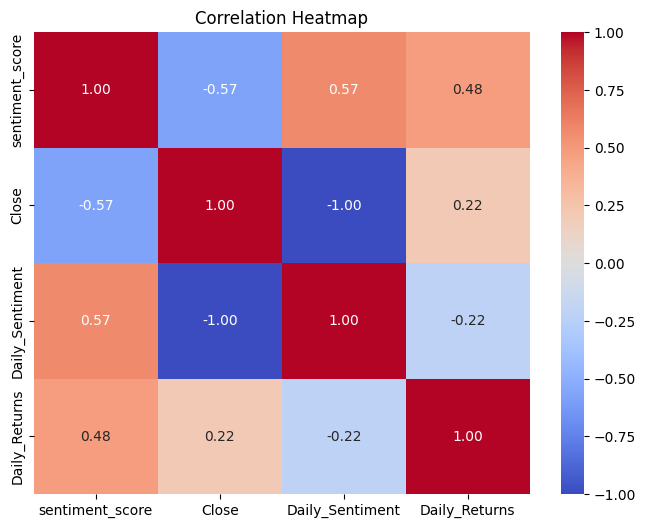

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sample data (replace with your actual combined_data DataFrame)
data = {'date': ['2020-06-09', '2020-06-09', '2020-06-10', '2020-06-10', '2020-06-10', '2020-06-10', '2020-06-10', '2020-06-10'],
        'headline': ['Apple shares...', 'Sonos Shares...', 'Tech Stocks...', '10 Biggest...', 'Benzinga Pro\'s...', 'Deutsche Bank...', 'Apple To Let...', 'Big Tech Reaches...'],
        'sentiment_score': [0.5472, 0.4404, 0.5574, 0.0000, 0.2023, 0.0000, 0.3818, 0.0516],
        'Close': [85.997498, 85.997498, 88.209999, 88.209999, 88.209999, 88.209999, 88.209999, 88.209999],
        'Daily_Sentiment': [0.32920, 0.32920, 0.19885, 0.19885, 0.19885, 0.19885, 0.19885, 0.19885],
        'Daily_Returns': [0.0, 0.0, 0.025728, 0.0, 0.0, 0.0, 0.0, 0.0]}
combined_data = pd.DataFrame(data)


# Select the columns for the heatmap
heatmap_data = combined_data[['sentiment_score', 'Close', 'Daily_Sentiment', 'Daily_Returns']]

# Calculate the correlation matrix
correlation_matrix = heatmap_data.corr()

# Create the heatmap using seaborn
plt.figure(figsize=(8, 6))  # Adjust figure size as needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()